# Imports & Settings

In [1]:
#!pip install fredapi
#!pip install yfinance

In [2]:
from datetime import datetime
from dateutil.relativedelta import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

import statsmodels.api as sm

import yfinance as yf
from fredapi import Fred

In [3]:
fred = Fred(api_key='5bc31fcec2681d6fff569153f9d526a5')

# Get Data

In [4]:
start_date = datetime.strptime('2001-01-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2018-01-01', '%Y-%m-%d').date() - relativedelta(days=1)

In [5]:
symbols = ['XLF', 'XLU', 'XLY', 'XLP', 'XLE', 'XLV', 'XLI', 'XLK', 'XLB']

data = yf.download(symbols, start_date, end_date)['Adj Close']
data

[*********************100%***********************]  9 of 9 completed


,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2001-01-02,13.100848,19.265089,15.039468,20.055573,22.580984,16.827780,15.282171,18.767025,19.708088
2001-01-03,13.178832,18.676914,15.850858,20.926638,26.216904,16.053553,14.960741,20.247753,21.263031
2001-01-04,13.617476,18.097780,15.572203,21.094551,26.480030,15.419246,14.726983,20.842274,21.564375
2001-01-05,13.334796,18.486889,15.244358,20.485851,24.877344,15.521856,14.580882,20.281393,20.853195
2001-01-08,13.373783,18.423544,15.088648,20.317938,24.805595,15.624460,14.800037,19.989748,20.575972
...,...,...,...,...,...,...,...,...,...
2017-12-22,55.096062,57.412903,25.603245,69.573174,61.268219,50.376591,45.356384,76.722847,94.438965
2017-12-26,55.050400,57.915462,25.530224,69.646980,60.860012,50.491749,45.088310,76.741341,94.648857
2017-12-27,55.123447,57.724007,25.557608,69.813065,60.926468,50.482895,45.278553,76.870918,94.458046


In [6]:
real_r = pd.DataFrame(fred.get_series('REAINTRATREARAT1MO', start_date, end_date)).reset_index()
real_r.columns = ['Date', '1 month real interest rate']
real_r['Date'] = real_r['Date'].apply(lambda x: x.date())
real_r.set_index(['Date'], inplace=True)
real_r

,1 month real interest rate
Date,
2001-01-01,4.494359
2001-02-01,2.215173
2001-03-01,4.667222
2001-04-01,2.602578
2001-05-01,1.587856
...,...
2017-08-01,-0.190892
2017-09-01,-1.340262
2017-10-01,-1.014069


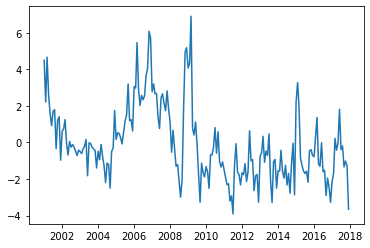

In [7]:
plt.plot(real_r)

In [8]:
gdp = pd.DataFrame(fred.get_series('GDI', 
                                   start_date, 
                                   end_date + relativedelta(months=1))).reset_index()
gdp.columns = ['Date', 'GDP Quarterly']
gdp['Date'] = gdp['Date'].apply(lambda x: x.date())
gdp.set_index(['Date'], inplace=True)
gdp

,GDP Quarterly
Date,
2001-01-01,10684.269
2001-04-01,10728.773
2001-07-01,10711.357
2001-10-01,10658.388
2002-01-01,10824.060
...,...
2017-01-01,19271.818
2017-04-01,19480.369
2017-07-01,19673.578


In [9]:
def get_gdp_monthly_df(gdp, start_date, end_date):
    gdp_dict = defaultdict(list)
    
    while (start_date < end_date - relativedelta(months=2)):
        gdp_dict['Date'].append(start_date)
        gdp_dict['GDP Monthly'].append(gdp[start_date:]['GDP Quarterly'].iloc[0])
        mean_gdp = np.mean(gdp[start_date : start_date + relativedelta(months=3)]['GDP Quarterly'])
        for i in range(2):
            start_date += relativedelta(months=1)
            gdp_dict['Date'].append(start_date)
            gdp_dict['GDP Monthly'].append(mean_gdp)
        
        start_date += relativedelta(months=1)

    gdp_df = pd.DataFrame(gdp_dict).set_index('Date')
    return gdp_df

In [10]:
gdp_df = get_gdp_monthly_df(gdp, start_date, end_date)
gdp_df

,GDP Monthly
Date,
2001-01-01,10684.2690
2001-02-01,10706.5210
2001-03-01,10706.5210
2001-04-01,10728.7730
2001-05-01,10720.0650
...,...
2017-08-01,19820.9465
2017-09-01,19820.9465
2017-10-01,19968.3150


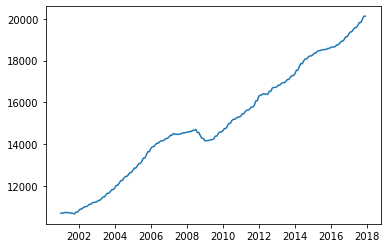

In [11]:
plt.plot(gdp_df);

In [12]:
def get_mean_price(data, start_date, end_date):
    mean_price_dict = defaultdict(list)
    
    while (start_date < end_date):
        mean_price_dict['Date'].append(start_date)
        
        for symbol in data.columns:
            mean_price = np.mean(data[start_date : start_date + relativedelta(months=1)][symbol])
            mean_price_dict[symbol].append(mean_price)
        
        start_date += relativedelta(months=1)
    
    mean_price_df = pd.DataFrame(mean_price_dict).set_index('Date')
    return mean_price_df

In [13]:
mean_price_df = get_mean_price(data, start_date, end_date)
mean_price_df

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2001-01-01,12.768437,18.308474,15.226617,20.779960,27.360933,15.681894,14.688585,20.790862,20.887346
2001-02-01,12.937090,18.955184,14.996258,20.371001,24.641973,15.977663,14.925212,20.907071,21.029284
2001-03-01,13.109279,18.553551,13.872923,18.826036,20.493371,14.932131,14.428811,19.566509,20.183370
2001-04-01,13.413891,18.597741,14.079803,18.931152,20.334182,14.724189,15.013830,19.951372,20.401441
2001-05-01,14.530408,19.398041,14.907938,20.714662,22.339030,15.307212,15.452010,21.206393,21.649568
...,...,...,...,...,...,...,...,...,...
2017-08-01,49.085621,49.842943,22.548220,62.206431,54.436520,48.171894,46.278071,72.821980,85.052528
2017-09-01,50.854319,52.243682,22.659983,63.742719,55.336284,48.083492,46.332766,75.443722,85.172552
2017-10-01,53.028101,53.883972,23.996841,66.111652,57.467227,47.370531,46.510968,76.161685,86.798047


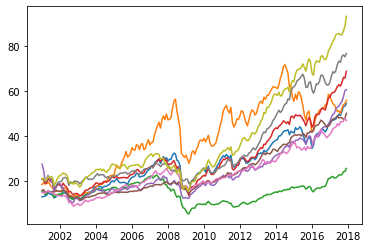

In [14]:
plt.plot(mean_price_df);

# Regression and Results

In [15]:
x = pd.concat([real_r['1 month real interest rate'], gdp_df['GDP Monthly']], axis=1)
x

,1 month real interest rate,GDP Monthly
Date,,
2001-01-01,4.494359,10684.2690
2001-02-01,2.215173,10706.5210
2001-03-01,4.667222,10706.5210
2001-04-01,2.602578,10728.7730
2001-05-01,1.587856,10720.0650
...,...,...
2017-08-01,-0.190892,19820.9465
2017-09-01,-1.340262,19820.9465
2017-10-01,-1.014069,19968.3150


In [16]:
def regression_result(x, y):
    X = sm.add_constant(x)
    result = sm.OLS(y, X).fit()
    print(result.summary())

In [17]:
symbol = 'XLF'
print(f"{symbol} Regression Results:\n")
regression_result(x, y=(mean_price_df[symbol]).tolist())

XLF Regression Results:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     18.05
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           6.15e-08
Time:                        22:51:01   Log-Likelihood:                -564.36
No. Observations:                 204   AIC:                             1135.
Df Residuals:                     201   BIC:                             1145.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [18]:
symbol = 'XLU'
print(f"{symbol} Regression Results:\n")
regression_result(x, y=(mean_price_df[symbol]).tolist())

XLU Regression Results:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     977.2
Date:                Mon, 08 Aug 2022   Prob (F-statistic):          2.82e-104
Time:                        22:51:01   Log-Likelihood:                -511.75
No. Observations:                 204   AIC:                             1029.
Df Residuals:                     201   BIC:                             1039.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [19]:
symbol = 'XLY'
print(f"{symbol} Regression Results:\n")
regression_result(x, y=(mean_price_df[symbol]).tolist())

XLY Regression Results:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     432.8
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           1.44e-73
Time:                        22:51:01   Log-Likelihood:                -737.18
No. Observations:                 204   AIC:                             1480.
Df Residuals:                     201   BIC:                             1490.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [20]:
symbol = 'XLP'
print(f"{symbol} Regression Results:\n")
regression_result(x, y=(mean_price_df[symbol]).tolist())

XLP Regression Results:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     638.3
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           8.50e-88
Time:                        22:51:01   Log-Likelihood:                -581.47
No. Observations:                 204   AIC:                             1169.
Df Residuals:                     201   BIC:                             1179.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [21]:
symbol = 'XLE'
print(f"{symbol} Regression Results:\n")
regression_result(x, y=(mean_price_df[symbol]).tolist())

XLE Regression Results:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     415.4
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           4.03e-72
Time:                        22:51:01   Log-Likelihood:                -686.16
No. Observations:                 204   AIC:                             1378.
Df Residuals:                     201   BIC:                             1388.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [22]:
symbol = 'XLV'
print(f"{symbol} Regression Results:\n")
regression_result(x, y=(mean_price_df[symbol]).tolist())

XLV Regression Results:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     393.1
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           3.41e-70
Time:                        22:51:01   Log-Likelihood:                -708.74
No. Observations:                 204   AIC:                             1423.
Df Residuals:                     201   BIC:                             1433.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [23]:
symbol = 'XLI'
print(f"{symbol} Regression Results:\n")
regression_result(x, y=(mean_price_df[symbol]).tolist())

XLI Regression Results:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     530.4
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           6.66e-81
Time:                        22:51:01   Log-Likelihood:                -633.36
No. Observations:                 204   AIC:                             1273.
Df Residuals:                     201   BIC:                             1283.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [24]:
symbol = 'XLK'
print(f"{symbol} Regression Results:\n")
regression_result(x, y=(mean_price_df[symbol]).tolist())

XLK Regression Results:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     290.3
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           5.28e-60
Time:                        22:51:01   Log-Likelihood:                -644.51
No. Observations:                 204   AIC:                             1295.
Df Residuals:                     201   BIC:                             1305.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [25]:
symbol = 'XLB'
print(f"{symbol} Regression Results:\n")
regression_result(x, y=(mean_price_df[symbol]).tolist())

XLB Regression Results:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     1190.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):          3.76e-112
Time:                        22:51:01   Log-Likelihood:                -513.31
No. Observations:                 204   AIC:                             1033.
Df Residuals:                     201   BIC:                             1043.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------